In [1]:
import os

import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from models.unet_vanilla import UNet
from preprocessing.preprocessor import ImagePreprocessor
from utils.trainer import Callback, SummaryWriter, trainer, batch_generator
from utils.evaluation import analyzer, jaccard_loss, dice_loss

### Определим вспомогательный функционал

In [2]:
# Препроцессор
P = ImagePreprocessor()

# Параметры изображений
input_size = 256
output_size = 164

# Изображение, на сегментацию которого хотим посмотреть
region = "ventura"
# region = "santa_rosa"

### Выберем модель, результат которой хотим посмотреть

In [3]:
# model = torch.load("saved_models/test_0.9/BCELoss()/small_UNet.Adam.0.0001")
# model = torch.load("saved_models/test_0.75/BCELoss()/small_UNet.Adam.0.0001")
model = torch.load("saved_models/test_0.5/BCELoss()/small_UNet.Adam.0.0001")

# model = torch.load("saved_models/test_0.9/MSELoss()/small_UNet.Adam.0.0001")
# model = torch.load("saved_models/test_0.75/MSELoss()/small_UNet.Adam.0.0001")
# model = torch.load("saved_models/test_0.5/MSELoss()/small_UNet.Adam.0.0001")

print(model)

UNet(
  (encoder): ModuleList(
    (0): UNetEncoderConvBlock(
      (conv_block): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU(inplace=True)
        (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
        (4): ReLU(inplace=True)
      )
      (max_pooling_2x2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): UNetEncoderConvBlock(
      (conv_block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
        (1): ReLU(inplace=True)
        (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
        (4): ReLU(inplace=True)
      )
      (max_pooling_2x2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): UNetEncoderConvBlock(
      (conv_blo

### Откроем изображение и преобразуем его в тензорный формат

In [4]:
# Открываем изображения
img, segm = P.read_image(dir=region)

# Нарезаем их в тензорном виде
images = P.destruct_to_chunks(img, chunk_size=output_size, output_size=input_size, mask=False, as_tensor=True)
segments = P.destruct_to_chunks(segm, chunk_size=output_size, output_size=input_size, mask=True, as_tensor=True)

print(images.shape, segments.shape)

torch.Size([784, 3, 256, 256]) torch.Size([784, 1, 164, 164])


### Получим прогнозы модели по нарезанным чанкам

In [ ]:
# Заводим тензор под хранение прогнозов
predicts = torch.zeros((len(images), 1, 164, 164))

for i in tqdm(range(len(images))):
    predicts[i:i+1] = model(images[i:i+1]).detach()
    
print(predicts.shape)

  0%|          | 0/784 [00:00<?, ?it/s]

### Сравним теперь визуально сегментацию модели с истинной

In [ ]:
# Получаем список np.ndarray с чанками исходного изображения / сегментации / прогноза модели
img_chunks = [P.to_img(images[i]) for i in range(len(images))]
segm_chunks = [P.to_img(segments[i]) for i in range(len(segments))]
pred_chunks = [P.to_img(predicts[i]) for i in range(len(predicts))]

# Затем объединяем полученные чанки обратно в цельное изображение
rec_img = P.unite(img_chunks, chunk_size=164, mask=False)
rec_segm = P.unite(segm_chunks, chunk_size=164, mask=True)
rec_pred = P.unite(pred_chunks, chunk_size=164, mask=True)

### Отрисуем результаты сегментации нейронной сетью и реальной

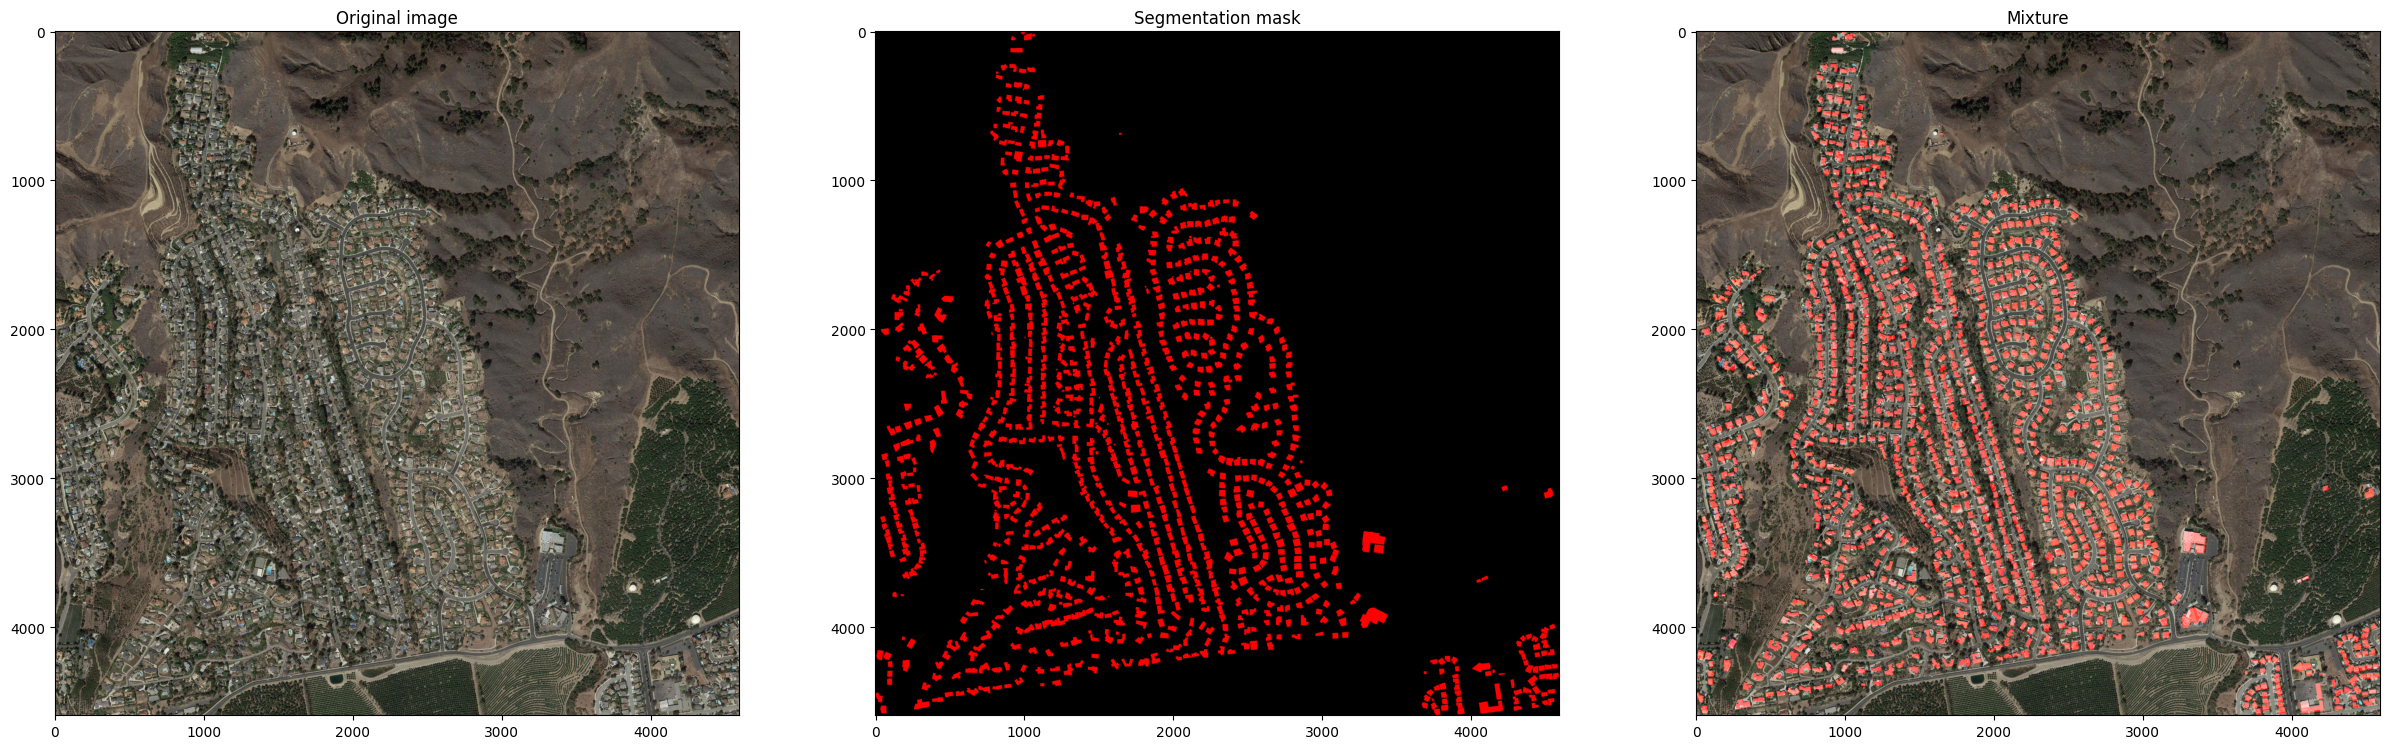

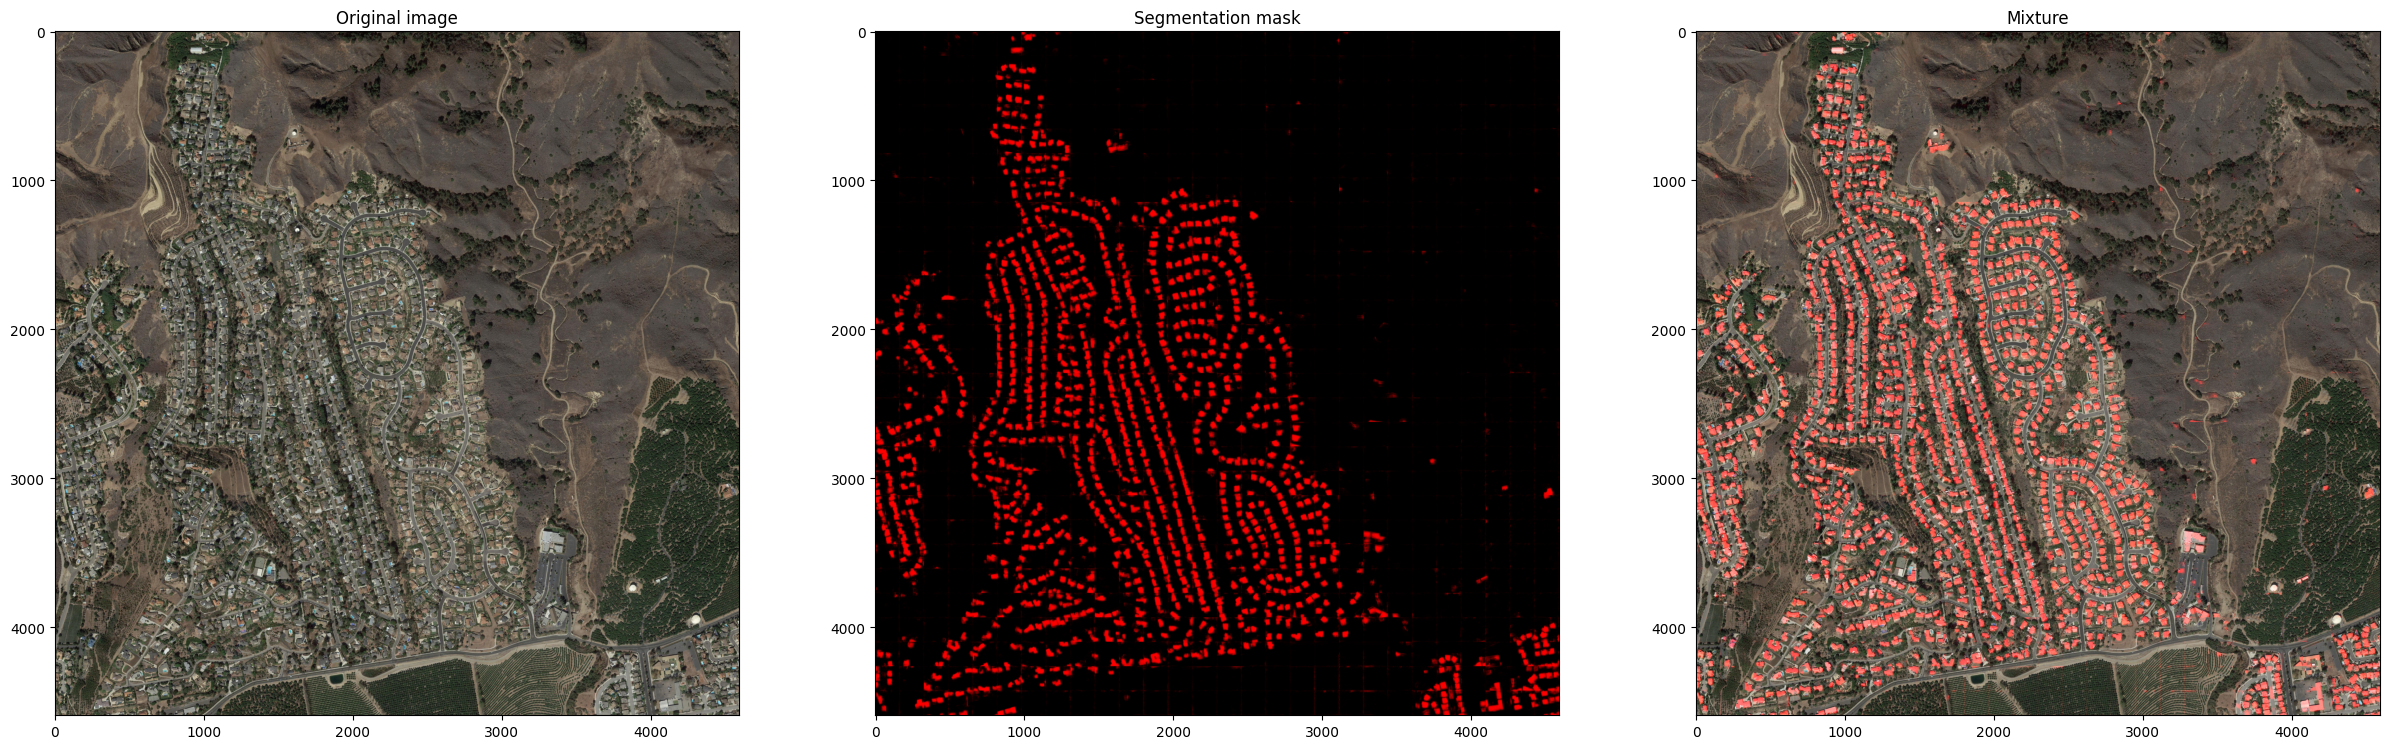

In [13]:
# Истинная разметка
P.show(rec_img, rec_segm)

# Предсказанная разметка 
P.show(rec_img, rec_pred)

$$$$
$$$$
$$$$
$$$$
$$$$
$$$$

# Произведём количественную оценку всех наших моделей 

Для того отрисуем два графика оценок моделей:

1. Используя IoU 
2. Используя Dice loss

### Оценка при помощи IoU

  0%|          | 0/784 [00:00<?, ?it/s]

  0%|          | 0/784 [00:00<?, ?it/s]

  0%|          | 0/784 [00:00<?, ?it/s]

  0%|          | 0/784 [00:00<?, ?it/s]

  0%|          | 0/784 [00:00<?, ?it/s]

  0%|          | 0/784 [00:00<?, ?it/s]

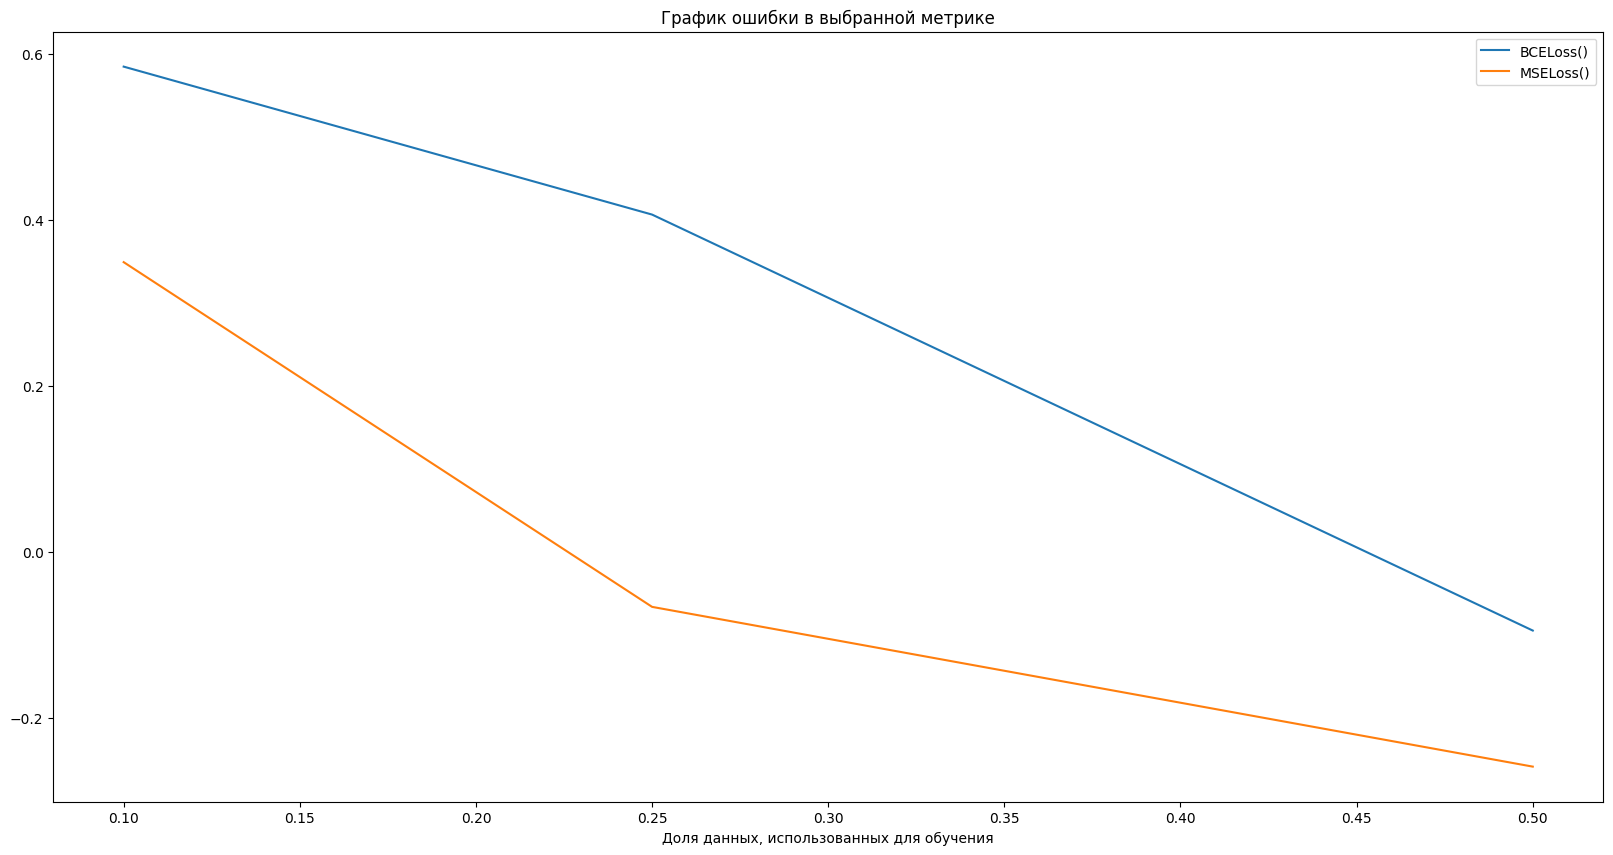

In [14]:
analyzer(images, rec_segm, jaccard_loss)

### Оценка при помощи Dice Loss

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

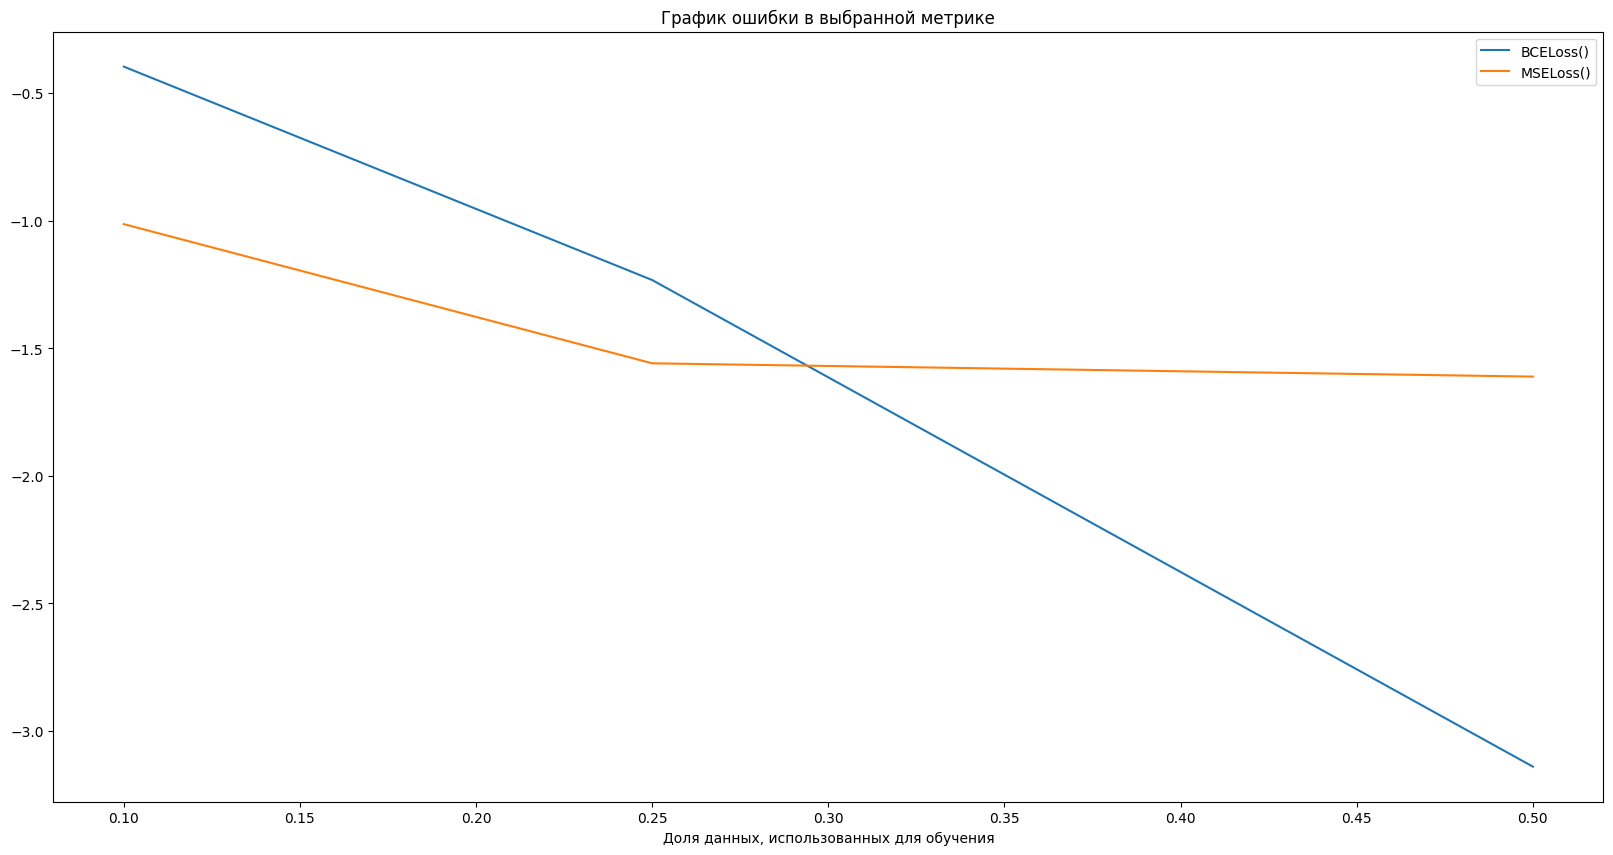

In [9]:
analyzer(images, rec_segm, dice_loss)